# RBC Classification - Complete Workflow
This notebook combines data preparation, model training, and evaluation into a single workflow.

## Workflow Steps:
1. **Setup & Configuration** - Import libraries and set parameters
2. **Data Preparation** - Load, preprocess, and split image data
3. **Model Definition** - Build CNN and baseline models
4. **Training** - Train models and visualize learning curves
5. **Evaluation** - Test models and generate reports

## 1. Setup & Configuration

In [5]:
# Import all required libraries
import os
import json
from pathlib import Path
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.20.0
NumPy version: 2.3.2


In [6]:
# Configuration Parameters

# Data preparation parameters
DATASET_DIR = "bloodcells_dataset"  # Change this to your dataset path
IMG_SIZE = 224
VAL_FRAC = 0.15
TEST_FRAC = 0.15
LIMIT_PER_CLASS = None  # Set to a number to limit images per class
SEGMENTATION_THRESHOLD = 0.3

# Training parameters
EPOCHS = 10
BATCH_SIZE = 32

# Output paths
OUT_DIR = "./artifacts"
OUT_NPZ = os.path.join(OUT_DIR, "rbc_data.npz")

# Create output directories
for d in [OUT_DIR, f"{OUT_DIR}/models", f"{OUT_DIR}/plots", f"{OUT_DIR}/reports"]:
    os.makedirs(d, exist_ok=True)

print(f"Dataset directory: {os.path.abspath(DATASET_DIR)}")
print(f"Output directory: {os.path.abspath(OUT_DIR)}")

Dataset directory: /Users/lemon/Documents/Python/BME 4790/Project 1/bloodcells_dataset
Output directory: /Users/lemon/Documents/Python/BME 4790/Project 1/artifacts


## 2. Data Preparation Functions

In [7]:
# Image file extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def get_class_names(dataset_dir: str) -> List[str]:
    """Get sorted list of class names from dataset directory."""
    names = [d.name for d in Path(dataset_dir).iterdir() if d.is_dir()]
    names = sorted(names)
    if not names:
        raise ValueError(f"No class folders found under {dataset_dir}")
    return names

def segment_image(arr: np.ndarray, threshold: float = SEGMENTATION_THRESHOLD) -> np.ndarray:
    """Apply segmentation by setting pixel values below threshold to zero."""
    # Convert to grayscale for thresholding
    grayscale = 0.299 * arr[:, :, 0] + 0.587 * arr[:, :, 1] + 0.114 * arr[:, :, 2]
    mask = grayscale >= threshold
    segmented = arr.copy()
    segmented[~mask] = 0.0
    return segmented

def process_image(im: Image.Image) -> np.ndarray:
    """Apply image processing steps to a PIL Image."""
    # Resize to target size
    im = im.resize((IMG_SIZE, IMG_SIZE))
    
    # Optional preprocessing steps (uncomment as needed)
    # im = ImageOps.equalize(im)
    # im = ImageOps.autocontrast(im)
    # im = im.filter(ImageFilter.MedianFilter(size=3))
    
    # Convert to numpy array and normalize
    arr = np.asarray(im, dtype=np.float32) / 255.0
    
    # Apply segmentation
    arr = segment_image(arr, threshold=SEGMENTATION_THRESHOLD)
    
    return arr

def load_images(dataset_dir: str, class_names: List[str]):
    """Load all images from dataset directory."""
    X_list, y_list = [], []
    
    for cls_idx, cls_name in enumerate(class_names, start=1):
        folder = Path(dataset_dir) / cls_name
        files = sorted([p for p in folder.iterdir() if p.suffix.lower() in IMG_EXTS])
        
        if LIMIT_PER_CLASS is not None:
            files = files[:LIMIT_PER_CLASS]
        
        print(f"Loading {len(files)} images from {cls_name}...")
        
        for p in files:
            im = Image.open(p).convert("RGB")
            arr = process_image(im)
            im.close()
            X_list.append(arr)
            y_list.append(cls_idx)
    
    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y

def split_data(X, y):
    """Split data into train, validation, and test sets."""
    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(VAL_FRAC + TEST_FRAC), 
        stratify=y, 
        random_state=42
    )
    
    # Second split: val vs test
    val_ratio = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=(1 - val_ratio), 
        stratify=y_temp, 
        random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

print("Data preparation functions loaded!")

Data preparation functions loaded!


## 3. Load and Prepare Dataset

In [8]:
# Get class names
class_names = get_class_names(DATASET_DIR)
print(f"Classes found: {class_names}")
num_classes = len(class_names)

# Load images
print("\nLoading images...")
X, y = load_images(DATASET_DIR, class_names)
print(f"Loaded: X shape = {X.shape}, y shape = {y.shape}")

# Split data
print("\nSplitting data...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

# Save processed data
meta = {"class_names": class_names, "img_size": IMG_SIZE}
np.savez_compressed(
    OUT_NPZ,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    meta=json.dumps(meta)
)
print(f"\nSaved processed data to: {os.path.abspath(OUT_NPZ)}")

Classes found: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

Loading images...
Loading 1218 images from basophil...
Loading 3117 images from eosinophil...
Loading 1551 images from erythroblast...
Loading 2895 images from ig...
Loading 1214 images from lymphocyte...
Loading 1420 images from monocyte...
Loading 3329 images from neutrophil...
Loading 2348 images from platelet...
Loaded: X shape = (17092, 224, 224, 3), y shape = (17092,)

Splitting data...
Train: (11964, 224, 224, 3)
Val:   (2564, 224, 224, 3)
Test:  (2564, 224, 224, 3)

Saved processed data to: /Users/lemon/Documents/Python/BME 4790/Project 1/artifacts/rbc_data.npz


## 4. Visualize Sample Images

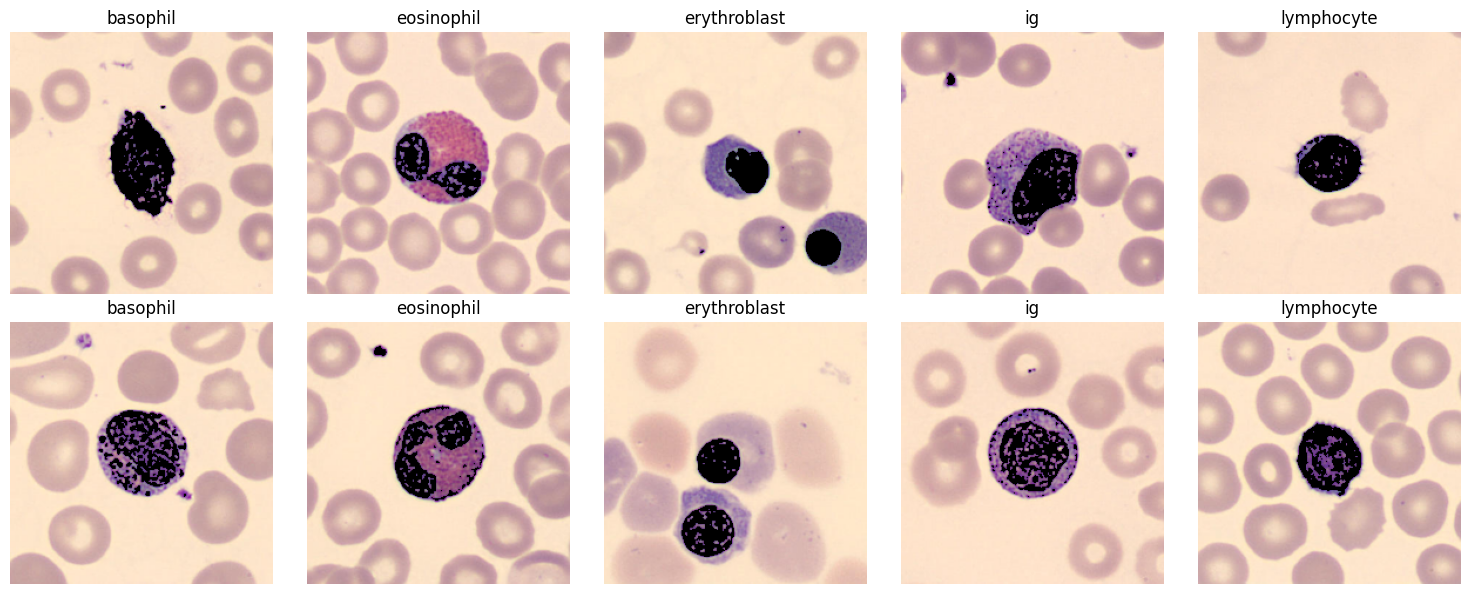

In [9]:
# Display sample images from each class
fig, axes = plt.subplots(2, min(5, num_classes), figsize=(15, 6))
if num_classes == 1:
    axes = axes.reshape(-1, 1)

for i in range(min(num_classes, 5)):
    # Find first two images of this class
    class_id = i + 1
    idx = np.where(y_train == class_id)[0][:2]
    
    for j, img_idx in enumerate(idx):
        ax = axes[j, i] if num_classes > 1 else axes[j]
        ax.imshow(X_train[img_idx])
        ax.set_title(f"{class_names[i]}")
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/plots/sample_images.png", dpi=150, bbox_inches='tight')
plt.show()

## 4.5. Visualize Image Processing Pipeline

This section shows the effect of preprocessing: Original → Segmented (RGB Version)

In [ ]:
# Load a few original images to show processing steps
def visualize_processing_pipeline(dataset_dir, class_names, num_samples=3):
    """Visualize the image processing pipeline: Original RGB → Segmented."""
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_count = 0
    for cls_idx, cls_name in enumerate(class_names):
        if sample_count >= num_samples:
            break
        
        folder = Path(dataset_dir) / cls_name
        files = sorted([p for p in folder.iterdir() if p.suffix.lower() in IMG_EXTS])
        
        if not files:
            continue
        
        # Take first image from this class
        img_path = files[0]
        
        # Step 1: Original RGB
        im_rgb = Image.open(img_path).convert("RGB")
        im_rgb_resized = im_rgb.resize((IMG_SIZE, IMG_SIZE))
        arr_rgb = np.asarray(im_rgb_resized, dtype=np.float32) / 255.0
        
        # Step 2: Apply full processing (including segmentation)
        arr_processed = process_image(im_rgb)
        
        # Plot
        axes[sample_count, 0].imshow(arr_rgb)
        axes[sample_count, 0].set_title(f"{cls_name}\nOriginal RGB")
        axes[sample_count, 0].axis('off')
        
        axes[sample_count, 1].imshow(arr_processed)
        axes[sample_count, 1].set_title(f"After Processing\n(with segmentation, threshold={SEGMENTATION_THRESHOLD})")
        axes[sample_count, 1].axis('off')
        
        im_rgb.close()
        sample_count += 1
    
    plt.suptitle('Image Processing Pipeline (RGB Version)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/processing_pipeline.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Processing pipeline visualization saved to: {OUT_DIR}/plots/processing_pipeline.png")

# Visualize processing for 3 sample images
visualize_processing_pipeline(DATASET_DIR, class_names, num_samples=min(3, num_classes))

## 5. Model Building Functions

In [10]:
def build_tiny_cnn(input_shape, num_classes):
    """Build a small CNN model."""
    return tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

def build_logreg_baseline(input_shape, num_classes):
    """Build a logistic regression baseline."""
    return tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax")
    ])

print("Model building functions loaded!")

Model building functions loaded!


## 6. Training and Evaluation Functions

In [11]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train a model and plot training curves."""
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train - 1, num_classes=num_classes)
    y_val_cat = to_categorical(y_val - 1, num_classes=num_classes)
    
    # Compile model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train model
    print(f"\nTraining {model_name}...")
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_training.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    return history

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and generate confusion matrix and classification report."""
    # Get predictions
    y_true = (y_test - 1).astype(int)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Test Accuracy: {acc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.colorbar()
    
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    
    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_cm.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(f"\n{model_name} Classification Report:")
    print(report)
    
    # Save report to file
    with open(f"{OUT_DIR}/reports/{model_name}_report.txt", "w") as f:
        f.write(f"Test Accuracy: {acc:.4f}\n\n")
        f.write(report)
    
    return acc

print("Training and evaluation functions loaded!")

Training and evaluation functions loaded!


## 7. Train CNN Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,428,200 (24.52 MB)

 Trainable params: 6,428,200 (24.52 MB)

 Non-trainable params: 0 (0.00 B)


Training tiny_cnn...
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 62s 164ms/step - accuracy: 0.5675 - loss: 1.2363 - val_accuracy: 0.7695 - val_loss: 0.7238
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 57s 153ms/step - accuracy: 0.8383 - loss: 0.4933 - val_accuracy: 0.8393 - val_loss: 0.4987
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 55s 146ms/step - accuracy: 0.8991 - loss: 0.3033 - val_accuracy: 0.8549 - val_loss: 0.4046
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 57s 152ms/step - accuracy: 0.9279 - loss: 0.2053 - val_accuracy: 0.8768 - val_loss: 0.3552
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - accuracy: 0.9544 - loss: 0.1383 - val_accuracy: 0.8756 - val_loss: 0.3646
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - accuracy: 0.9789 - loss: 0.0741 - val_accuracy: 0.8810 - val_loss: 0.3818
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 56s 150ms/step - accuracy: 0.9869 - loss: 0.0495 - val_accuracy: 0.8920 - val_loss: 0.3633
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 55s 148ms/step - accu

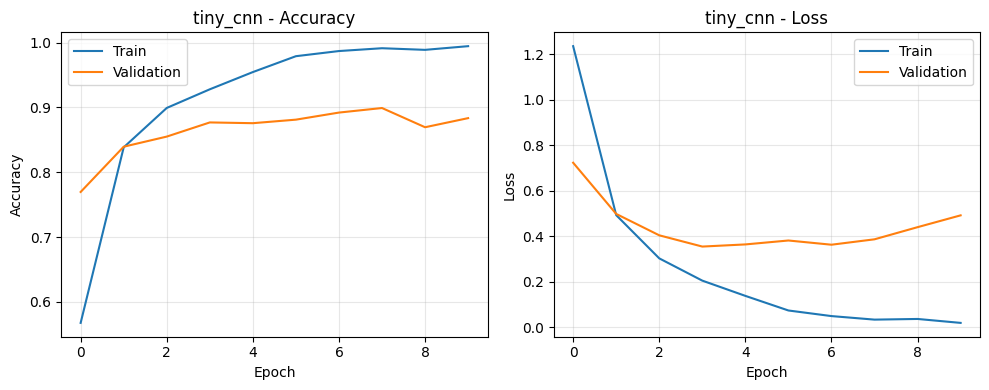


CNN model saved to: ./artifacts/models/tiny_cnn.keras


In [12]:
# Build CNN model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
cnn_model = build_tiny_cnn(input_shape, num_classes)
cnn_model.summary()

# Train CNN
cnn_history = train_model(cnn_model, X_train, y_train, X_val, y_val, "tiny_cnn")

# Save model
cnn_model.save(f"{OUT_DIR}/models/tiny_cnn.keras")
print(f"\nCNN model saved to: {OUT_DIR}/models/tiny_cnn.keras")

## 8. Evaluate CNN Model


tiny_cnn Test Accuracy: 0.8912


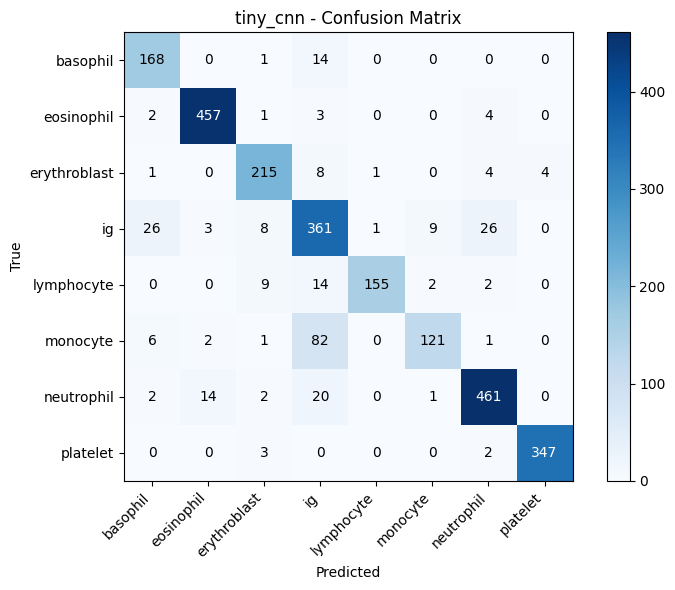


tiny_cnn Classification Report:
              precision    recall  f1-score   support

    basophil     0.8195    0.9180    0.8660       183
  eosinophil     0.9601    0.9786    0.9692       467
erythroblast     0.8958    0.9227    0.9091       233
          ig     0.7191    0.8318    0.7714       434
  lymphocyte     0.9873    0.8516    0.9145       182
    monocyte     0.9098    0.5681    0.6994       213
  neutrophil     0.9220    0.9220    0.9220       500
    platelet     0.9886    0.9858    0.9872       352

    accuracy                         0.8912      2564
   macro avg     0.9003    0.8723    0.8798      2564
weighted avg     0.8977    0.8912    0.8899      2564



In [13]:
cnn_accuracy = evaluate_model(cnn_model, X_test, y_test, "tiny_cnn")

## 9. Train Logistic Regression Baseline

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │     1,204,232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,232 (4.59 MB)

 Trainable params: 1,204,232 (4.59 MB)

 Non-trainable params: 0 (0.00 B)


Training logreg...
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4340 - loss: 22.5442 - val_accuracy: 0.5566 - val_loss: 10.1507
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5474 - loss: 9.4629 - val_accuracy: 0.5761 - val_loss: 8.8999
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5961 - loss: 8.8000 - val_accuracy: 0.4891 - val_loss: 17.2059
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6244 - loss: 8.5795 - val_accuracy: 0.6700 - val_loss: 6.8476
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6581 - loss: 7.4057 - val_accuracy: 0.6135 - val_loss: 13.6923
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6576 - loss: 8.1881 - val_accuracy: 0.6291 - val_loss: 11.2119
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6850 - loss: 7.1814 - val_accuracy: 0.6509 - val_loss: 7.7588
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6742

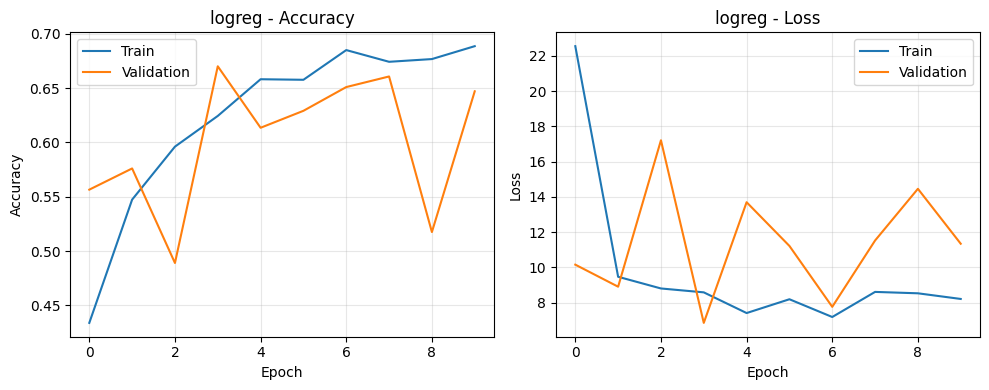


Logistic regression model saved to: ./artifacts/models/logreg.keras


In [14]:
# Build logistic regression model
logreg_model = build_logreg_baseline(input_shape, num_classes)
logreg_model.summary()

# Train logistic regression
logreg_history = train_model(logreg_model, X_train, y_train, X_val, y_val, "logreg")

# Save model
logreg_model.save(f"{OUT_DIR}/models/logreg.keras")
print(f"\nLogistic regression model saved to: {OUT_DIR}/models/logreg.keras")

## 10. Evaluate Logistic Regression Baseline


logreg Test Accuracy: 0.6736


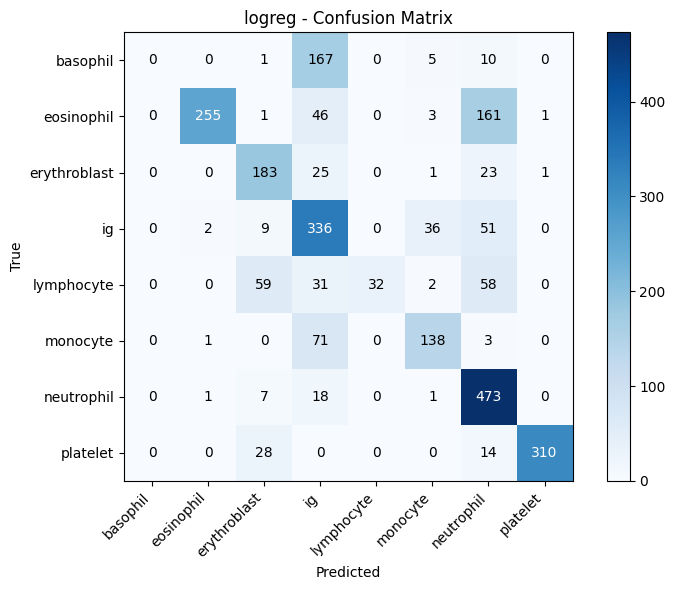


logreg Classification Report:
              precision    recall  f1-score   support

    basophil     0.0000    0.0000    0.0000       183
  eosinophil     0.9846    0.5460    0.7025       467
erythroblast     0.6354    0.7854    0.7025       233
          ig     0.4841    0.7742    0.5957       434
  lymphocyte     1.0000    0.1758    0.2991       182
    monocyte     0.7419    0.6479    0.6917       213
  neutrophil     0.5965    0.9460    0.7316       500
    platelet     0.9936    0.8807    0.9337       352

    accuracy                         0.6736      2564
   macro avg     0.6795    0.5945    0.5821      2564
weighted avg     0.7044    0.6736    0.6422      2564



/Users/lemon/Documents/Python/BME 4790/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lemon/Documents/Python/BME 4790/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lemon/Documents/Python/BME 4790/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [15]:
logreg_accuracy = evaluate_model(logreg_model, X_test, y_test, "logreg")

## 11. Compare Models


MODEL COMPARISON
Tiny CNN Test Accuracy:        0.8912
Logistic Regression Accuracy:  0.6736
Improvement:                   0.2176


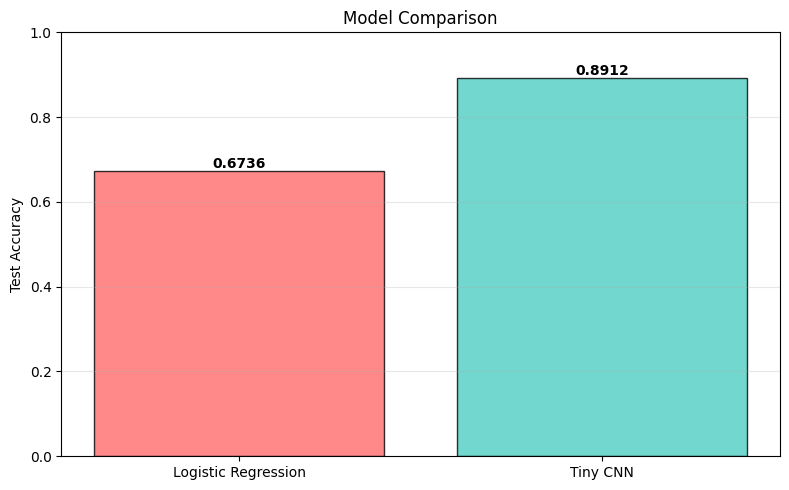

In [16]:
# Compare model accuracies
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Tiny CNN Test Accuracy:        {cnn_accuracy:.4f}")
print(f"Logistic Regression Accuracy:  {logreg_accuracy:.4f}")
print(f"Improvement:                   {(cnn_accuracy - logreg_accuracy):.4f}")
print("="*50)

# Bar plot comparison
plt.figure(figsize=(8, 5))
models = ['Logistic Regression', 'Tiny CNN']
accuracies = [logreg_accuracy, cnn_accuracy]
colors = ['#FF6B6B', '#4ECDC4']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/plots/model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 12. Summary

### Workflow Complete!

This notebook has:
1. ✅ Loaded and preprocessed images from the dataset
2. ✅ Applied segmentation to isolate cells
3. ✅ Split data into train/validation/test sets
4. ✅ Built and trained a CNN model
5. ✅ Built and trained a logistic regression baseline
6. ✅ Evaluated both models on the test set
7. ✅ Generated confusion matrices and classification reports
8. ✅ Saved all models, plots, and reports

### Output Files:
- **Models**: `./artifacts/models/` (tiny_cnn.keras, logreg.keras)
- **Plots**: `./artifacts/plots/` (training curves, confusion matrices)
- **Reports**: `./artifacts/reports/` (classification reports)
- **Data**: `./artifacts/rbc_data.npz` (preprocessed dataset)

### Next Steps:
- Experiment with different preprocessing techniques (uncomment in `process_image()`)
- Adjust `SEGMENTATION_THRESHOLD` for better cell isolation
- Try different model architectures
- Increase `EPOCHS` for potentially better performance
- Add data augmentation for improved generalization